In [1]:
import os
import numpy as np 
import pandas as pd
import pickle as pkl 
from functools import partial
from itertools import product
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb

from outliers import OUT_handler  # my own class to handle outliers
from ohe_topN import OHE_topN # my own class to handle catdata

from hyperopt import fmin, hp, Trials, tpe, STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope as ho_scope

import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import missingno as msno
import warnings

SEED = 32

In [2]:
def plot_relations(df, feats, file_name, ncols=10):
    '''Relationship between mis. values and target'''    
    
    dft = df.copy()
    n = len(feats)
    
    fig, axes = plt.subplots(nrows=np.ceil(n/ncols).astype(int), 
                              ncols=ncols, figsize=(3*ncols, np.ceil(n/ncols)*3))
    
    for idx, feat in enumerate(feats):
        
        dft[feat] = np.where(dft[feat].isna(), 1, 0)
        groups = dft.groupby(trg)
        ax=axes[idx//ncols, idx%ncols]
        ax.set_title(feat)
        
        for name, group in groups:
            ax.bar(name, group[feat].mean(), label=name, align='center')
    
    fig.suptitle('Relationship between MVs and target')
    fig.tight_layout()
    fig.savefig(f'media/{file_name}')

In [3]:
PATH_DIR = '../../../bases/telecom-clients-prediction2'
FILE_NAME_TRAIN = 'orange_small_churn_train_data.csv'
FILE_NAME_TEST = 'orange_small_churn_test_data.csv'
PATH_FILE_TRAIN = os.path.join(PATH_DIR, FILE_NAME_TRAIN)
PATH_FILE_TEST = os.path.join(PATH_DIR, FILE_NAME_TEST)

In [4]:
df_train = pd.read_csv(PATH_FILE_TRAIN, index_col='ID')

feats_num = df_train.columns[:190]
feats_cat = df_train.columns[190:-1]
trg = df_train.columns[-1]
print('shape of raw train data:', df_train.shape)
X_test = pd.read_csv(PATH_FILE_TEST, index_col='ID')
print('shape of raw test data:', X_test.shape)

shape of raw train data: (18299, 231)
shape of raw test data: (10000, 230)


In [5]:
#%% drop elements where target is nan
df_train.drop(np.where(df_train.iloc[:, -1].isna())[0], axis=0, inplace=True)
print('train: shape of nan-target: ', df_train.shape)  # (18298, 231)

train: shape of nan-target:  (18298, 231)


In [6]:
#%% split data and save test set
print('split data to train, valid')
X_train, X_valid, y_train, y_valid = train_test_split(
                    df_train.iloc[:, :-1], 
                    df_train.iloc[:, -1],                    
                    test_size=0.25, shuffle=True, 
                    stratify=df_train.iloc[:, -1], random_state=SEED)

df_train = pd.concat([X_train, y_train], axis=1)
print('shape of X_train:', X_train.shape)
print('shape of X_valid:', X_valid.shape)
print('shape of X_test:', X_test.shape)

split data to train, valid
shape of X_train: (13723, 230)
shape of X_valid: (4575, 230)
shape of X_test: (10000, 230)


In [7]:
#%% Remove completly nan columns 
feats_num = X_train[feats_num].dropna(how='all', axis=1).columns.tolist()
feats_cat = X_train[feats_cat].dropna(how='all', axis=1).columns.tolist()
feats = feats_num + feats_cat 
print('shape of X_train:', X_train[feats].shape)

shape of X_train: (13723, 212)


In [8]:
#%% Drop feats with nan more than 0.925
print('Length of numerical feats before dropping', len(feats_num))
mask = (X_train[feats_num].isna().mean() < 0.925)

feats_num = X_train[feats_num].columns[mask].tolist()
print('Length of numeric vals after dropping: ', len(feats_num))
feats = feats_cat + feats_num

Length of numerical feats before dropping 174
Length of numeric vals after dropping:  43


In [9]:
prop = (df_train.iloc[:, -1].value_counts()/len(df_train)).round(3).to_dict()
# {-1.0: 0.925, 1.0: 0.075}
print('Proportions of churn', prop)

Proportions of churn {-1.0: 0.925, 1.0: 0.075}


In [10]:
prop = (df_train.iloc[:, -1].value_counts()/len(df_train)).round(3).to_dict()
# {-1.0: 0.925, 1.0: 0.075}
print('Proportions of churn', prop)

Proportions of churn {-1.0: 0.925, 1.0: 0.075}


In [11]:
#%% feats with high cardinality to categorical feats

feats_tocat = []
for feat in feats_num:
    card = X_train[feat].value_counts().size   # cardinality
    if card < 30:
        feats_tocat.append(feat)

print('The number of feats from numerical to categorical features is', len(feats_tocat))
feats_num = list(filter(lambda feat: feat not in feats_tocat, feats_num))        
X_train.loc[:, feats_tocat] = X_train[feats_tocat].astype(str)
X_test.loc[:, feats_tocat] = X_test[feats_tocat].astype(str)
X_train.loc[:, feats_tocat] = X_train[feats_tocat].replace('nan', np.nan)
X_test.loc[:, feats_tocat] = X_test[feats_tocat].replace('nan', np.nan)
feats_cat = feats_cat + feats_tocat

The number of feats from numerical to categorical features is 11


##### Numerical features

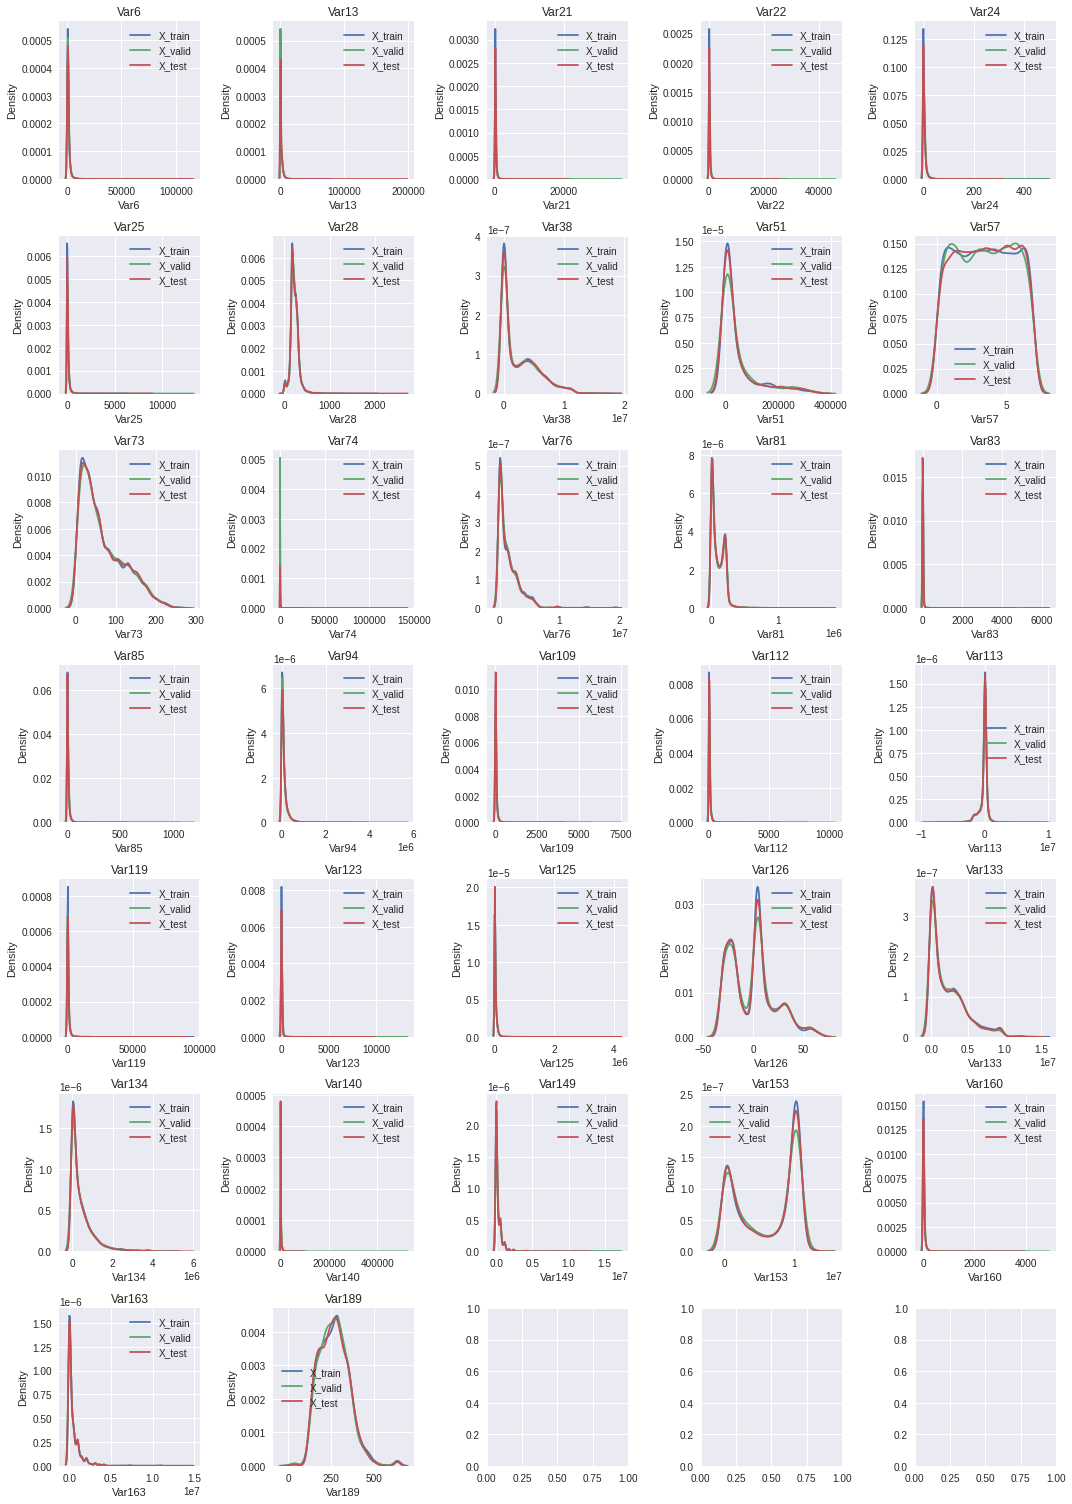

In [12]:
#%% plot kde of train, valid, test sets

n = len(feats_num)
ncols = 5
nrows = int(np.ceil(n/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

for idx, feat in enumerate(feats_num[:n]):
    
    ax = axes[idx//ncols, idx%ncols]
    sns.kdeplot(x=X_train[feat], ax=ax, alpha=0.5, label='X_train')
    sns.kdeplot(x=X_valid[feat], ax=ax, alpha=0.5, label='X_valid')
    sns.kdeplot(x=X_test[feat], ax=ax, alpha=0.5, label='X_test')
    ax.set_title(feat)
    ax.legend()

fig.tight_layout()    
# fig.savefig('media/feats_num_kde_tr_vl_ts.png')
plt.show()

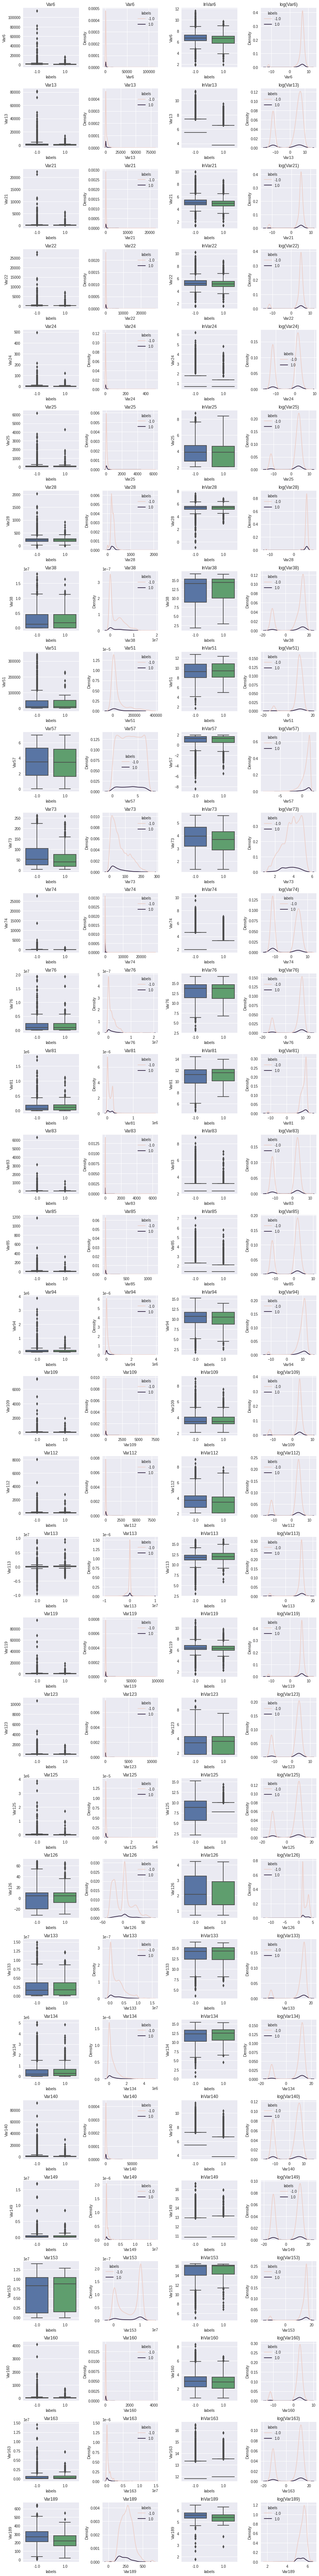

In [13]:
#%% plot: boxplot, kde, boxplot log(x), kde log(x)  

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    nrows = len(feats_num)
    ncols = 4

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
    feat = feats_num[0]

    for idx, feat in enumerate(feats_num[:nrows]):

        sns.boxplot(y=X_train[feat], ax=axes[idx, 0], x=y_train)
        axes[idx, 0].set_title(feat)
        sns.kdeplot(x=feat, data=X_train, hue=y_train, ax=axes[idx, 1])
        axes[idx, 1].set_title(feat)
        sns.boxplot(y=X_train[feat].apply(np.log), ax=axes[idx, 2], x=y_train)
        axes[idx, 2].set_title(f'ln{feat}')
        sns.kdeplot(x=X_train[feat].apply(lambda x: np.log(x+1e-5)), hue=y_train, ax=axes[idx, 3])
        axes[idx, 3].set_title(f'log({feat})')

fig.tight_layout()
# fig.savefig('media/log_boxplot_kde.png')
plt.show()

In [14]:
#%% feats to log-transform

feats_tolog = [6, 21, 22, 25, 94, 109, 119, 123, 125, 160]
feats_tolog = [f'Var{var}' for var in feats_tolog]

feats_tolater = [13, 24, 74, 83, 85, 112, 140, 149]
feats_tolater = [f'Var{var}' for var in feats_tolater]

feats_torem = set(feats_num)-set(feats_tolog)-set(feats_tolater)
feats_torem = sorted(feats_torem, key=lambda x: int(x[3:]))
print('feats to log transform:', ' '.join(feats_torem), '\n')

for feat in feats_tolog:
    X_train[feat] = X_train[feat].apply(np.log)

feats to log transform: Var28 Var38 Var51 Var57 Var73 Var76 Var81 Var113 Var126 Var133 Var134 Var153 Var163 Var189 



##### HANDLING OUTLIERS (IQR method)

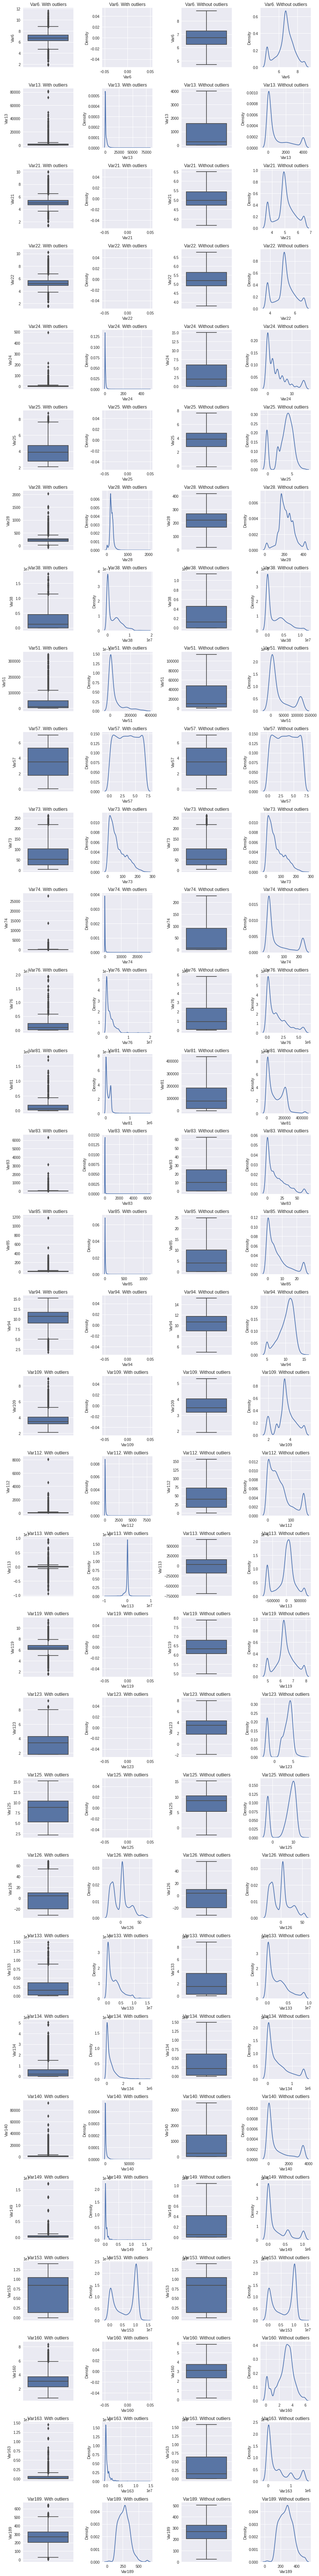

In [15]:
nrows = len(feats_num)
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    for idx, feat in enumerate(feats_num[:nrows]):

        sample = X_train.loc[:, feat] 
        ax=axes[idx, 0]
        sns.boxplot(y=sample , ax=axes[idx, 0])
        axes[idx, 0].set_title(f'{feat}. With outliers')
        sns.kdeplot(x=sample, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'{feat}. With outliers')

        # transformation train, valid, test
        handler = OUT_handler(method='iqr')
        handler.fit(sample.values)
        X_train.loc[:, feat] = handler.transform(sample) 
        X_valid.loc[:, feat] = handler.transform(X_valid.loc[:, feat])
        X_test.loc[:, feat] = handler.transform(X_test.loc[:, feat])

        sns.boxplot(y=sample, ax=axes[idx, 2])
        axes[idx, 2].set_title(f'{feat}. Without outliers')
        sns.kdeplot(x=sample, ax=axes[idx, 3])
        axes[idx, 3].set_title(f'{feat}. Without outliers')
    
fig.tight_layout()
# fig.savefig('media/outliers_handle.png')    
plt.show()

In [16]:
#%% save my train, valid and test sets for further processing

train_set_out = {
    'df_train': pd.concat([X_train[feats_num+feats_cat], y_train], axis=1),
    'feats_num': feats_num,
    'feats_cat': feats_cat
    }
with open('pkl/df_out_train.pkl', 'wb') as file:
    pkl.dump(train_set_out, file)
    
valid_set_out = {
    'df_valid': pd.concat([X_valid[feats_num+feats_cat], y_valid], axis=1),
    }
with open('pkl/df_out_valid.pkl', 'wb') as file:
    pkl.dump(valid_set_out, file)    

test_set_out = {
    'X_test': X_test[feats_num+feats_cat],
    }
with open('pkl/X_out_test.pkl', 'wb') as file:
    pkl.dump(test_set_out, file)   

##### Handling missing values

In [17]:
X_train.shape

(13723, 230)

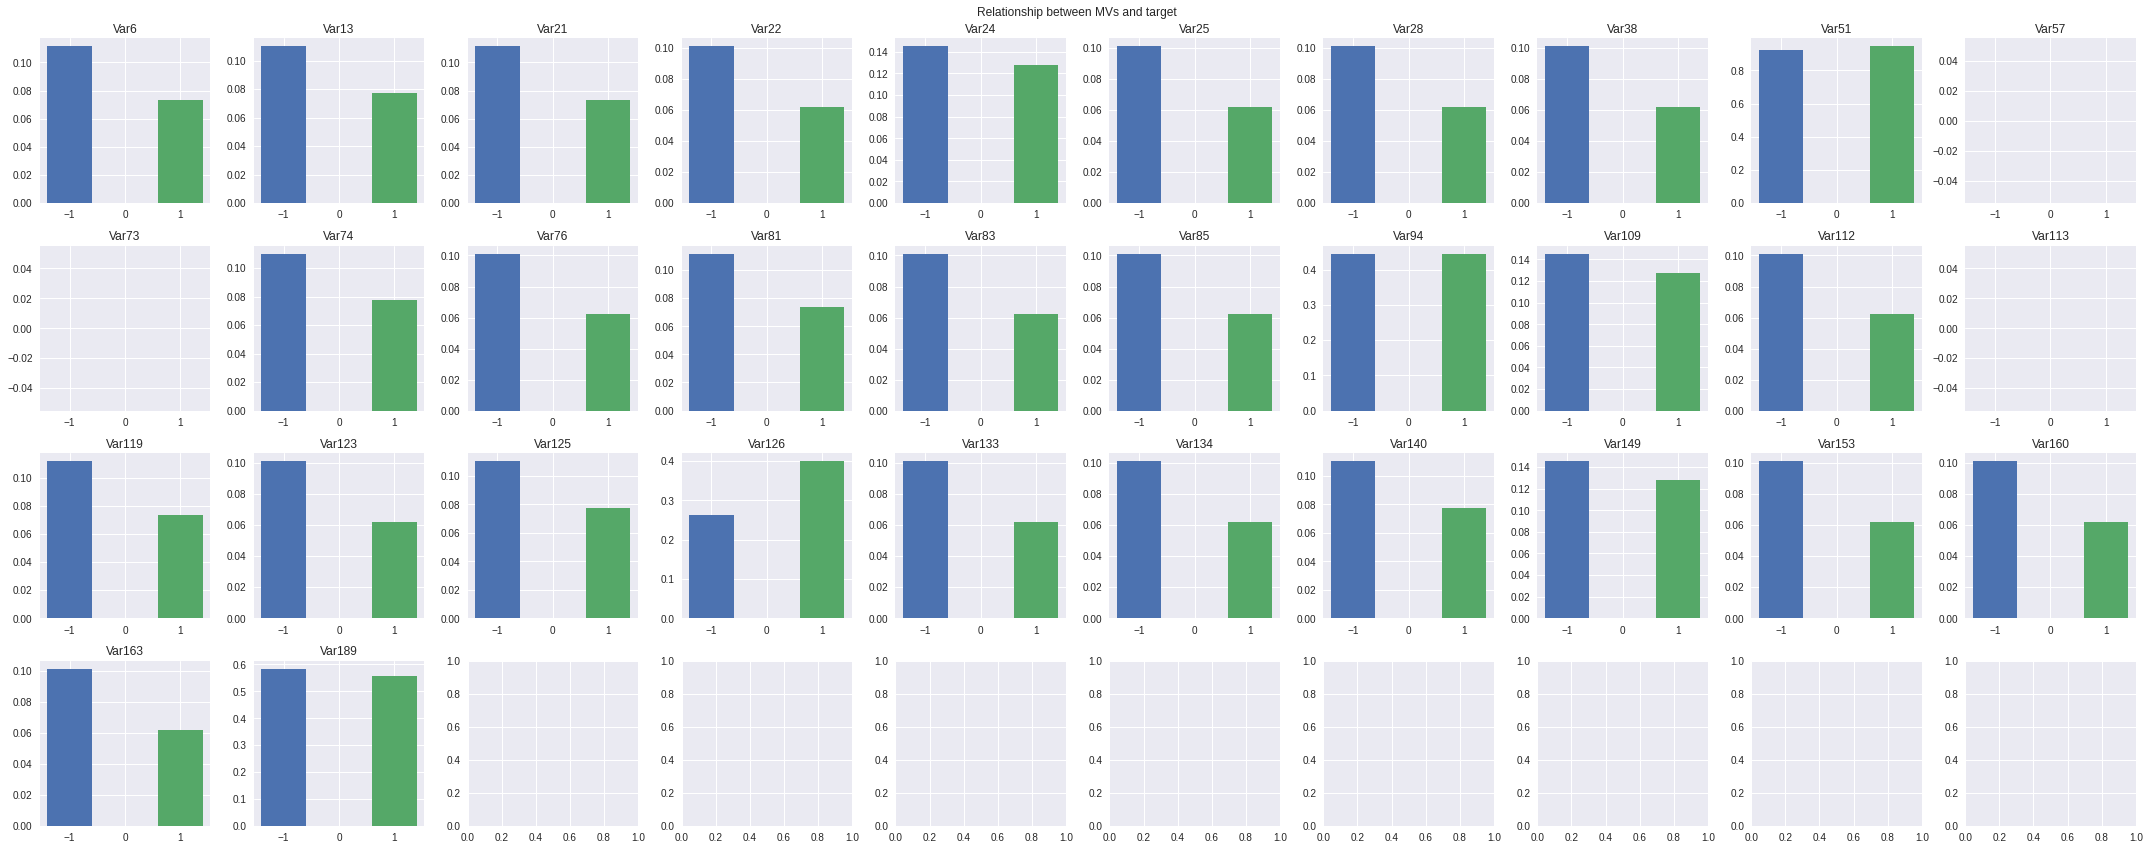

In [18]:
#%% Relationship between MVs and target
df_train = pd.concat([X_train[feats_num+feats_cat], y_train], axis=1)
plot_relations(df_train, feats_num, 'rels_num.png')

##### Numerical data. KNN Imputation.

In [19]:
imputer = KNNImputer()
imputer.fit(X_train[feats_num])

X_train[feats_num] = imputer.transform(X_train[feats_num])
X_valid[feats_num] = imputer.transform(X_valid[feats_num])
X_test[feats_num] = imputer.transform(X_test[feats_num])

mes = X_train[feats_num].isna().any().any()
print('X_train numerical feats isna any: ', mes)
mes = X_train[feats_num].isna().any().any()
print('X_valid numerical feats isna any:', mes)
mes = X_test[feats_num].isna().any().any()
print('X_test numerical feats isna any:', mes)

X_train numerical feats isna any:  False
X_valid numerical feats isna any: False
X_test numerical feats isna any: False


##### Categorical data. 

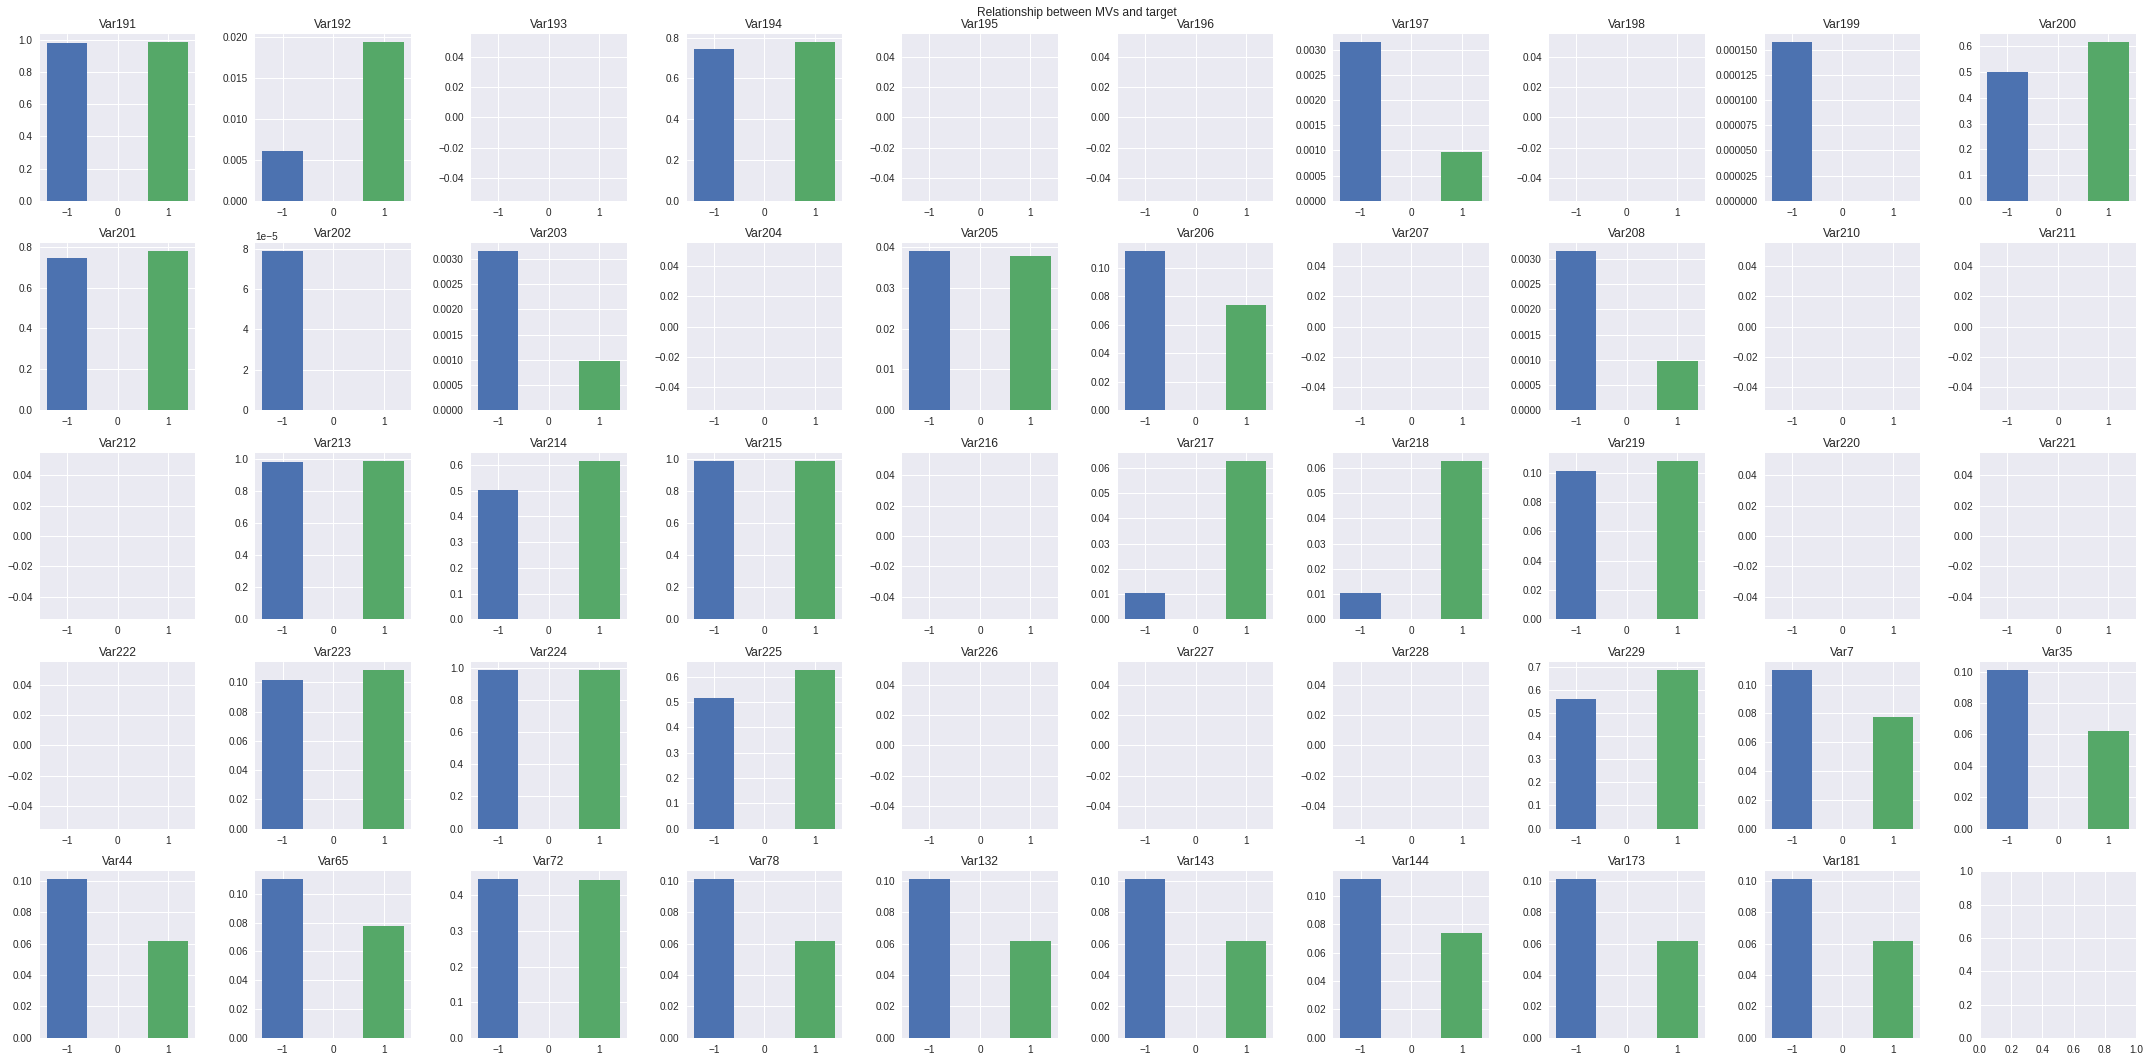

In [20]:
#%% Relationship between MVs and target

plot_relations(df_train, feats_cat, file_name='MV_targ_cat.png')

In [21]:
#%% delete some features
feats_to_del = [191, 201, 213, 215, 224] 
feats_to_del = [f'Var{col}' for col in feats_to_del]

feats_cat = list(filter(lambda feat: feat not in feats_to_del, feats_cat))

print('shape of X_train:', X_train.shape)
print('shape of X_valid:', X_valid.shape)
print('shape of X_test:', X_test.shape)

shape of X_train: (13723, 230)
shape of X_valid: (4575, 230)
shape of X_test: (10000, 230)


In [22]:
#%% MCNAR: using these feats create new feat: "isna_Var194" and in original feat replace feat with 'rare' - category.
print('\nCategorical data. Creating new features. And replacing nan values with "rare" category')
feats_to_new = [194, 197, 199, 200, 206, 214, 223, 225, 229]
feats_to_new = [f'Var{col}' for col in feats_to_new]

for feat in feats_to_new:
    
    new = 'isna_' + feat
    feats_cat.append(new)
    
    X_train[new] = np.where(X_train[feat].isna(), 'missing', 'existing')
    X_train[feat] = np.where(X_train[feat].isna(), 'rare', X_train[feat])
    
    X_valid[new] = np.where(X_valid[feat].isna(), 'missing', 'existing')
    X_valid[feat] = np.where(X_valid[feat].isna(), 'rare', X_valid[feat])
    
    X_test[new] = np.where(X_test[feat].isna(), 'missing', 'existing')
    X_test[feat] = np.where(X_test[feat].isna(), 'rare', X_test[feat])

print('\nCategorical data. Creating new features replacing nan values with "rare" category')
print('shape of df_train:', X_train.shape)
print('shape of df_valid:', X_valid.shape)
print('shape of df_test:', X_test.shape)


Categorical data. Creating new features. And replacing nan values with "rare" category

Categorical data. Creating new features replacing nan values with "rare" category
shape of df_train: (13723, 239)
shape of df_valid: (4575, 239)
shape of df_test: (10000, 239)


In [23]:
#%% MCAR: most frequent strategy
mask = X_train[feats_cat].isna().any()
feats_cat_na = X_train[feats_cat].columns[mask] 

for feat in feats_cat_na:

    top = X_train[feat].value_counts().nlargest(1).index.values[0]
    X_train[feat].fillna(top, inplace=True)
    X_valid[feat].fillna(top, inplace=True)
    X_test[feat].fillna(top, inplace=True)

print('\nCategorical data. MCAR: most_frequent')
print('shape of X_train:', X_train.shape)
print('shape of X_valid:', X_valid.shape)
print('shape of X_test:', X_test.shape)      


Categorical data. MCAR: most_frequent
shape of X_train: (13723, 239)
shape of X_valid: (4575, 239)
shape of X_test: (10000, 239)


In [24]:
#%% check nan
isna = X_train[feats_num + feats_cat].isna().any().any() # False
print('train is NaN any:', isna)
isna = X_valid[feats_num + feats_cat].isna().any().any() # False
print('valid is NaN any:', isna)
isna = X_test[feats_num+feats_cat].isna().any().any() # False
print('test is NaN any:', isna)

train is NaN any: False
valid is NaN any: False
test is NaN any: False


In [25]:
#%% convert target type to int
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

In [121]:

# #%% save my train, valid and test sets for further processing

# train_set_filled = {
#     'df_train': pd.concat([X_train[feats_num+feats_cat], y_train], axis=1),
#     'feats_num': feats_num,
#     'feats_cat': feats_cat
#     }
# with open('pkl/df_filled_train.pkl', 'wb') as file:
#     pkl.dump(train_set_filled, file)
   
# valid_set_filled = {
#     'df_valid': pd.concat([X_valid[feats_num+feats_cat], y_valid], axis=1),
#     }
# with open('pkl/df_filled_valid.pkl', 'wb') as file:
#     pkl.dump(valid_set_filled, file)    

# test_set_filled = {
#     'X_test': X_test[feats_num+feats_cat],
#     }
# with open('pkl/X_filled_test.pkl', 'wb') as file:
#     pkl.dump(test_set_filled, file)  
with open('pkl/df_filled_train.pkl', 'rb') as file:
    DATA = pkl.load(file)
    
df_train = DATA['df_train']
feats_num = DATA['feats_num']
feats_cat = DATA['feats_cat']

with open('pkl/df_filled_valid.pkl', 'rb') as file:
    DATA = pkl.load(file)
df_valid = DATA['df_valid']

with open('pkl/X_filled_test.pkl', 'rb') as file:
    DATA = pkl.load(file)
X_test = DATA['X_test']

print('shape of df_train:', df_train.shape)
print('shape of df_valid:', df_valid.shape)
print('shape of X_test:', X_test.shape)

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_valid = df_valid.iloc[:, :-1]
y_valid = df_valid.iloc[:, -1]

shape of df_train: (13723, 86)
shape of df_valid: (4575, 86)
shape of X_test: (10000, 85)


#### Preprocessing. Numerical features. 

In [122]:
print('Transformation of numerical features. Standard scaling.')

scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_train[feats_num])
X_num_train = pd.DataFrame(X_num_train, columns=feats_num, index=X_train.index)
X_num_valid = scaler.transform(X_valid[feats_num])
X_num_valid = pd.DataFrame(X_num_valid, columns=feats_num, index=X_valid.index)
X_num_test = scaler.fit_transform(X_test[feats_num])
X_num_test = pd.DataFrame(X_num_test, columns=feats_num)

Transformation of numerical features. Standard scaling.


#### Preprocessing. Categorical features. 

In [123]:
#%% One hot encoding with top 10 most frequent labels.
from pandas.core.common import SettingWithCopyWarning
encoder = OHE_topN(top_n=10)
print(f'Transformation of categorical features. {encoder.__class__.__name__}.')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    encoder.fit(X_train[feats_cat])
    X_cat_train = encoder.transform(X_train[feats_cat])
    X_cat_valid = encoder.transform(X_valid[feats_cat])
    X_cat_test = encoder.transform(X_test[feats_cat])
    feats_cat = X_cat_train.columns

Transformation of categorical features. OHE_topN.


In [124]:
#%% concatenatenate numerical and categorical data

X_clean_train = pd.concat([X_num_train, X_cat_train], axis=1)
X_clean_valid = pd.concat([X_num_valid, X_cat_valid], axis=1)
X_clean_test = pd.concat([X_num_test, X_cat_test], axis=1)
feats = X_clean_train.columns.tolist()

##### Get feature importancies.

In [125]:
def roc_auc_feval(preds, train_data):
    ''' loss-function'''
    score = roc_auc_score(y_valid, preds)
    return 'roc_auc_score', score, True 

In [126]:
#%% undersampling, fitting
rus = RandomUnderSampler(random_state=SEED)
X_res, y_res = rus.fit_resample(X_clean_train, y_train) 
train_set = lgb.Dataset(data=X_res, label=y_res, 
                        feature_name=X_res.columns.tolist())
valid_set = lgb.Dataset(data=X_clean_valid, label=y_valid,
                        feature_name=X_res.columns,
                        reference=train_set)
# params of the lgbm-model
params = {
    'num_leaves': 31
    }

lgbm = lgb.train(params=params, 
                  train_set=train_set, 
                  valid_sets=[valid_set],
                  num_boost_round=100, 
                  early_stopping_rounds=25,
                  feval=roc_auc_feval,
                  verbose_eval=10)

preds = lgbm.predict(X_res)
score = roc_auc_score(y_res, preds)
print('auc on resampled data', score.round(4))

preds = lgbm.predict(X_clean_train)
score = roc_auc_score(y_train, preds)
print('auc on train data', score.round(4))

preds = lgbm.predict(X_clean_valid)
score = roc_auc_score(y_valid, preds)
print('auc on valid data', score.round(4))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6090
[LightGBM] [Info] Number of data points in the train set: 2066, number of used features: 232
Training until validation scores don't improve for 25 rounds
[10]	valid_0's roc_auc_score: 0.660972
[20]	valid_0's roc_auc_score: 0.67807
[30]	valid_0's roc_auc_score: 0.679337
[40]	valid_0's roc_auc_score: 0.679438
[50]	valid_0's roc_auc_score: 0.678336
[60]	valid_0's roc_auc_score: 0.676014
Early stopping, best iteration is:
[39]	valid_0's roc_auc_score: 0.680905
auc on resampled data 0.9778
auc on train data 0.889
auc on valid data 0.6809


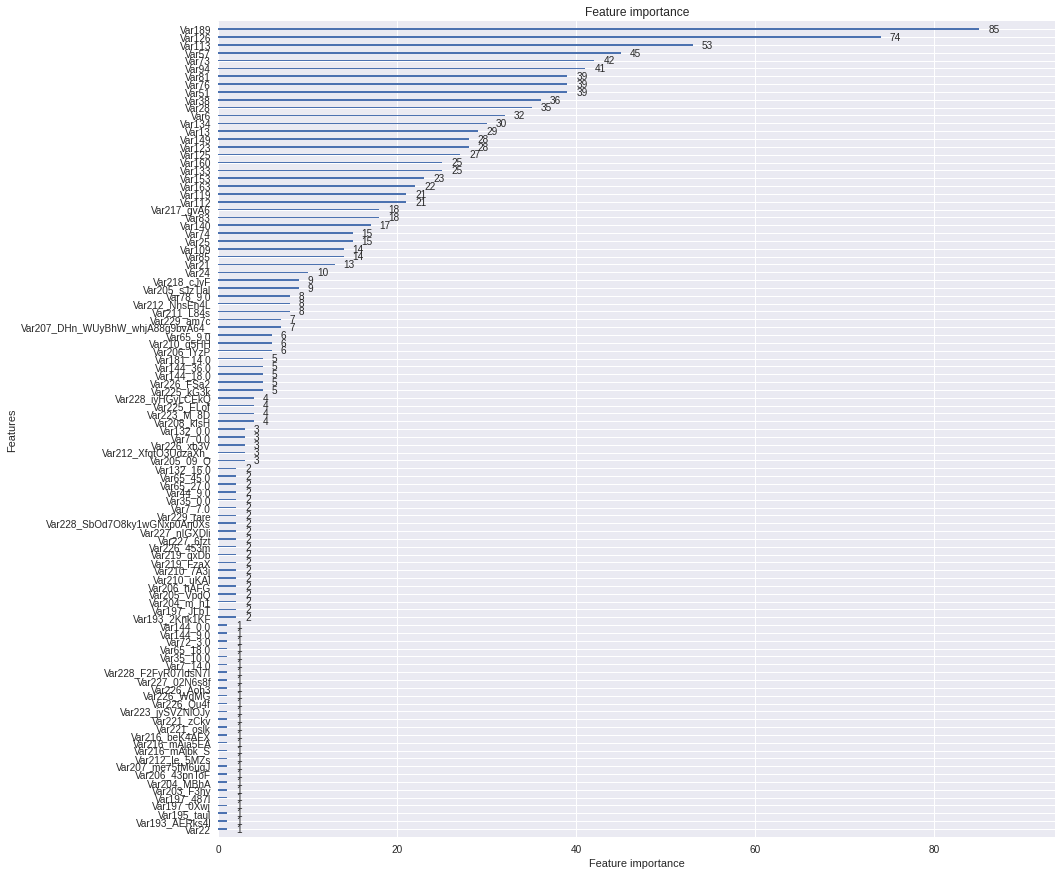

In [127]:
#%% plot feature importance

ax = lgb.plot_importance(lgbm, max_num_features=200, 
                         figsize=(15, 15))
# plt.savefig('media/lgbm.plot_importance.png')
plt.show()

In [128]:
#%% feature importance to dataframe 
 
df_fi = pd.DataFrame({'auc': lgbm.feature_importance(), 'feats': X_res.columns})
df_fi.index = X_res.columns
df_fi.sort_values(by='auc', ascending=False, inplace=True)
df_fi

,auc,feats
Var189,85,Var189
Var126,74,Var126
Var113,53,Var113
Var57,45,Var57
Var73,42,Var73
...,...,...
Var207_5iay,0,Var207_5iay
Var207_6C53VA1kCv,0,Var207_6C53VA1kCv
Var207_GjJ35utlTa_GNSvxxpb9ju,0,Var207_GjJ35utlTa_GNSvxxpb9ju
Var207_NKv3VA1BpP,0,Var207_NKv3VA1BpP


##### Feature selection

In [129]:
def fit(X_train, y_train, X_valid=X_clean_valid, y_valid=y_valid, params=None):
    '''functions to fit a model'''  
    # undersampling data
    rus = RandomUnderSampler(random_state=SEED)
    X_res, y_res = rus.fit_resample(X_train, y_train)
    
    # prepare to lgbm fitting
    train_set = lgb.Dataset(data=X_res, label=y_res, 
                            feature_name=X_res.columns.tolist())
    valid_set = lgb.Dataset(data=X_clean_valid, label=y_valid,
                            feature_name=X_res.columns,
                            reference=train_set)
    if not params:
        params = {'num_leaves': 31, 'force_col_wise': True, 'verbose': -1}
    
    # params of the lgbm-model
    lgbm = lgb.train(params=params, 
                      train_set=train_set, 
                      valid_sets=[valid_set],
                      num_boost_round=100, 
                      early_stopping_rounds=25,
                      feval=roc_auc_feval,
                      verbose_eval=0)
    
    return lgbm

lgbm = fit(X_clean_train, y_train)
lgbm

In [130]:
#%% Sequential forward selection using feature_importance

dct_res, dct_train, dct_valid, dct_test, iters = {}, {}, {}, {}, {}
n = len(df_fi.index)  # number of feature_importance
feats_selected = [] # feats that will be used in forward selection

for feat in tqdm(df_fi.index[:n]):
    
    feats_selected.append(feat)
    length = len(feats_selected)
    
    lgbm = fit(X_res[feats_selected], y_res)
    iters[length] = lgbm.best_iteration
    
    preds = lgbm.predict(X_res[feats_selected])
    score = roc_auc_score(y_res, preds)
    dct_res[length] = score.round(4)
    
    preds = lgbm.predict(X_res[feats_selected])
    score = roc_auc_score(y_res, preds)
    dct_train[length] = score.round(4)
    
    preds = lgbm.predict(X_clean_valid[feats_selected])
    score = roc_auc_score(y_valid, preds)
    dct_valid[length] = score.round(4)

dct = {'res': dct_res, 'train': dct_train, 'valid': dct_valid, 'n_estim': iters}
df_res = pd.DataFrame(dct)
with open('pkl/df_forw_sel.pkl', 'wb') as file:
    pkl.dump(df_res, file)
    
with open('pkl/df_forw_sel.pkl', 'rb') as file:
    df_res = pkl.load(file)  

df_res.sort_values(by='valid', ascending=False, inplace=True)
best = df_res.head(1).index.values[0]
feats_to_save = df_fi[:best].index 
print('The number of features that will be used to ML is', len(feats_to_save))

100%|███████████████████████████████| 384/384 [09:24<00:00,  1.47s/it]

The number of features that will be used to ML is 92


In [131]:
# %% save my clean train, valid and test sets for tuning model
# train_set_clean = {
#     'X_clean_train': X_clean_train[feats_to_save],
#     'y_train': y_train,
#     'feats_to_save': feats_to_save
#     }
# with open('pkl/data_clean_train.pkl', 'wb') as file:
#     pkl.dump(train_set_clean, file)
    
# valid_set_clean = {
#     'X_clean_valid': X_clean_valid[feats_to_save],
#     'y_valid': y_valid
#     }
# with open('pkl/data_clean_valid.pkl', 'wb') as file:
#     pkl.dump(valid_set_clean, file)    

# test_set_clean = {
#     'X_clean_test': X_clean_test[feats_to_save],
#     }
# with open('pkl/data_clean_test.pkl', 'wb') as file:
#     pkl.dump(test_set_clean, file)
#%% load data
with open('pkl/data_clean_train.pkl', 'rb') as file:
    DATA = pkl.load(file)
    
X_clean_train = DATA['X_clean_train']
y_train = DATA['y_train']    
feats = DATA['feats_to_save']

with open('pkl/data_clean_valid.pkl', 'rb') as file:
    DATA = pkl.load(file)
    
X_clean_valid = DATA['X_clean_valid']
y_valid = DATA['y_valid']    

with open('pkl/data_clean_test.pkl', 'rb') as file:
    DATA = pkl.load(file)    

##### Tune Model Hyperparameters

In [132]:
def objective(params, X_train, y_train):
    '''objective function fot hyperopt'''

    skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

    scores = []   # score at each iteration
#     import pdb; pdb.set_trace()    
    try: 
        for itrain, ivalid in skf.split(X_train, y_train):
            
            rus = RandomUnderSampler(random_state=SEED) 
            X_res, y_res = rus.fit_resample(X_train[itrain, :], y_train[itrain])
            eval_set = (X_train[ivalid, :], y_train[ivalid])
            gbm = lgb.LGBMClassifier(**params, n_estimators=1000, 
                                     verbose=-1)
            gbm.fit(X_res, y_res, 
                    eval_set=[eval_set],
                    early_stopping_rounds=25, 
                    eval_metric='auc',
                    verbose=0)
            
            score = dict(gbm.best_score_['valid_0'])['auc']
            scores.append(score)

        return {'loss': -np.mean(scores), 'params': params, 'status': STATUS_OK}
    
    except ValueError as e:

        return {'loss': None, 'params': params, 'status': STATUS_FAIL}

In [134]:
#%% HYPEROPT optimization

space = {
#     'objective': 'binary',   ########### delete
    'metric': 'auc',
    'force_col_wise': True,
    'class_weight':     hp.choice('class_weight', [None, 'balanced']),
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.01, 0.2, 0.02)),
    'num_leaves':       ho_scope.int(hp.quniform('num_leaves', 8, 128, 2)),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 20, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.5, 1),
    'reg_alpha':        hp.uniform('reg_alpha', 0.01, 1.0),
    'reg_lambda':       hp.uniform('reg_lambda', 0.01, 1.0),
}

trials = Trials()
best = fmin(fn=partial(objective, X_train=X_clean_train.values, y_train=y_train.values), 
            space=space, algo=tpe.suggest, 
            show_progressbar=True,
            max_evals=100, trials=trials,
            rstate=np.random.RandomState(SEED))

100%|█| 100/100 [05:32<00:00,  3.33s/trial, best loss: -0.718068389419


In [135]:
res = trials.results
res = [{**i, **i['params']} for i in res]

df_hyp = pd.DataFrame(res)
df_hyp['loss'] = df_hyp['loss'].apply(abs)
df_hyp.sort_values(by='loss', ascending=False, inplace=True)
df_hyp.drop(['params', 'status'], axis=1, inplace=True)

with open('pkl/hyperopt_10_ohe.pkl', 'wb') as file:
    pkl.dump(df_hyp, file)    

with open('pkl/hyperopt_10_ohe.pkl', 'rb') as file:
    df_hyp = pkl.load(file)  

df_hyp.head(5)

,loss,class_weight,colsample_bytree,force_col_wise,learning_rate,max_depth,metric,min_child_weight,num_leaves,reg_alpha,reg_lambda,subsample
79,0.718068,balanced,0.6,True,0.19,3,auc,7,56,0.575880,0.235850,0.892896
83,0.717423,balanced,0.6,True,0.19,3,auc,7,66,0.816770,0.650723,0.976962
65,0.716714,balanced,0.5,True,0.15,3,auc,7,120,0.460407,0.046762,0.952478
81,0.716282,balanced,0.6,True,0.19,3,auc,7,60,0.789369,0.560848,0.981082
31,0.715960,balanced,0.7,True,0.15,3,auc,7,48,0.487999,0.468901,0.937136


In [2]:
#%% Grid search using cross-validation
gridParams = {
    'learning_rate': np.arange(0.15, 0.21, 0.01),
    'class_weight': ['balanced'],
    'num_leaves': np.arange(50, 70, 10),
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'colsample_bytree' : np.arange(0.5, 0.65, 0.05),
    'subsample' : np.arange(0.85, 1.0, 0.1),
    'reg_alpha' : np.arange(0.45, 0.85, 5),
    'reg_lambda' : np.arange(0.35, 0.70, 0.05),
    }
n_iters = list(map(lambda x: len(x), gridParams.values()))
n_iters = np.prod(n_iters)
print('the number of parameters to iter is', n_iters)
#%%
# skf = StratifiedKFold(n_splits=3, random_state=SEED, shuffle=True)
# results = []

# for idx, prods in tqdm(enumerate(product(*gridParams.values()), start=1)):
    
#     params = {}
    
#     for key, val in zip(gridParams.keys(), prods):
    
#         params[key] = val
#         val_loss = []      # loss on validation set
#         cval_loss = []       # loss on validation set of cross_validation(X_train)   

#         for itrain, ivalid in skf.split(X_clean_train, y_train.values):
            
#             rus = RandomUnderSampler(random_state=SEED) 
#             X_res, y_res = rus.fit_resample(X_clean_train.values[itrain, :], y_train.values[itrain])
#             eval_set = (X_clean_train.values[ivalid, :], y_train.values[ivalid])
#             gbm = lgb.LGBMClassifier(**params, n_estimators=1000, 
#                                      n_jobs=1, verbose=-1, force_col_wise=True,
#                                      random_state=np.random.RandomState(SEED),)
#             gbm.fit(X_res, y_res, 
#                     eval_set=[eval_set],
#                     eval_metric = 'auc',
#                     early_stopping_rounds=25, 
#                     verbose=0)
            
#             cval_score = dict(gbm.best_score_['valid_0'])['auc']
#             cval_loss.append(cval_score)
            
#             preds = gbm.booster_.predict(X_clean_valid.values)
#             val_score = roc_auc_score(y_valid.values, preds)
#             val_loss.append(val_score)
        
#         results.append({
#             'cval_loss': np.mean(cval_loss),
#             'val_loss': np.mean(val_loss),
#             'params': params
#             }) 
# res = [{**x, **x['params']} for x in results]
# df_grid = pd.DataFrame(res)
# df_grid.drop('params', axis=1, inplace=True)
# df_grid.sort_values(by='val_loss', ascending=False, inplace=True)     

# with open('media/df_grid.pkl', 'wb') as file:
#     pkl.dump(df_grid, file)

with open('media/df_grid.pkl', 'rb') as file:
    df_grid = pkl.load(file)    
    
df_grid.head(5)  

the number of parameters to iter is 672


,cval_loss,val_loss,learning_rate,class_weight,num_leaves,boosting_type,objective,colsample_bytree,subsample,reg_alpha,reg_lambda
494,0.688472,0.685482,0.15,balanced,50,gbdt,binary,0.65,0.95,0.45,0.60
431,0.688472,0.685482,0.15,balanced,50,gbdt,binary,0.65,0.85,0.45,0.60
3446,0.680069,0.683032,0.18,balanced,50,gbdt,binary,0.65,0.85,0.45,0.55
3509,0.680069,0.683032,0.18,balanced,50,gbdt,binary,0.65,0.95,0.45,0.55
1502,0.683896,0.682922,0.16,balanced,50,gbdt,binary,0.65,0.95,0.45,0.60


In [10]:
# predict test data
with open('pkl/data_clean_train.pkl', 'rb') as file:
    data = pkl.load(file)
X_clean_train = data['X_clean_train']
y_train = data['y_train']

with open('pkl/data_clean_test.pkl', 'rb') as file:
    data = pkl.load(file)
X_clean_test = data['X_clean_test']    

rus = RandomUnderSampler(random_state=SEED) 
params = df_grid.head(1).drop(['cval_loss', 'val_loss'], axis=1).T.iloc[:, 0].to_dict()
X_res, y_res = rus.fit_resample(X_clean_train.values, y_train.values)
gbm = lgb.LGBMClassifier(**params, n_estimators=1000, 
                         n_jobs=1, verbose=-1, force_col_wise=True,
                         random_state=np.random.RandomState(SEED),)
gbm.fit(X_res, y_res, 
        eval_set=[(X_res, y_res)],
        eval_metric = 'auc',
        early_stopping_rounds=25, 
        verbose=-1)

preds = gbm.booster_.predict(X_clean_test)
pd.DataFrame(preds, columns=['prob'])

Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[85]	training's auc: 1	training's binary_logloss: 0.0974306


,prob
0,0.228160
1,0.187835
2,0.135328
3,0.460446
4,0.423632
...,...
9995,0.310913
9996,0.373443
9997,0.138371
9998,0.185955
